# Анализ временных рядов на основе датасета Microsoft Stock

In [ ]:
pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

In [ ]:
df = pd.read_csv('Microsoft_Stock.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [ ]:
df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M:%S')  # изменим тип данных в столбце Date
df

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012


In [ ]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


Видим, что в датасете нет пропусков, поэтому сделаем их искуственно, чтобы продемонстрировать возможности их заполнения

In [ ]:
np.random.seed(42)
missing_indices = np.random.choice(range(len(df)), size=50, replace=False)
df_with_na = df.copy()
df_with_na.loc[df_with_na.index[missing_indices], 'Close'] = np.nan

In [ ]:
print(f"Создано пропусков: {df_with_na['Close'].isna().sum()}")

Создано пропусков: 50


In [ ]:
missing_dates = df_with_na.index[missing_indices]

### Построим график, визуализирующий временной ряд. Охарактеризуем его, опишем есть ли тренд, сезонность или цикл

In [ ]:
df_corrected = df_with_na.copy()
df_corrected.set_index('Date', inplace=True)

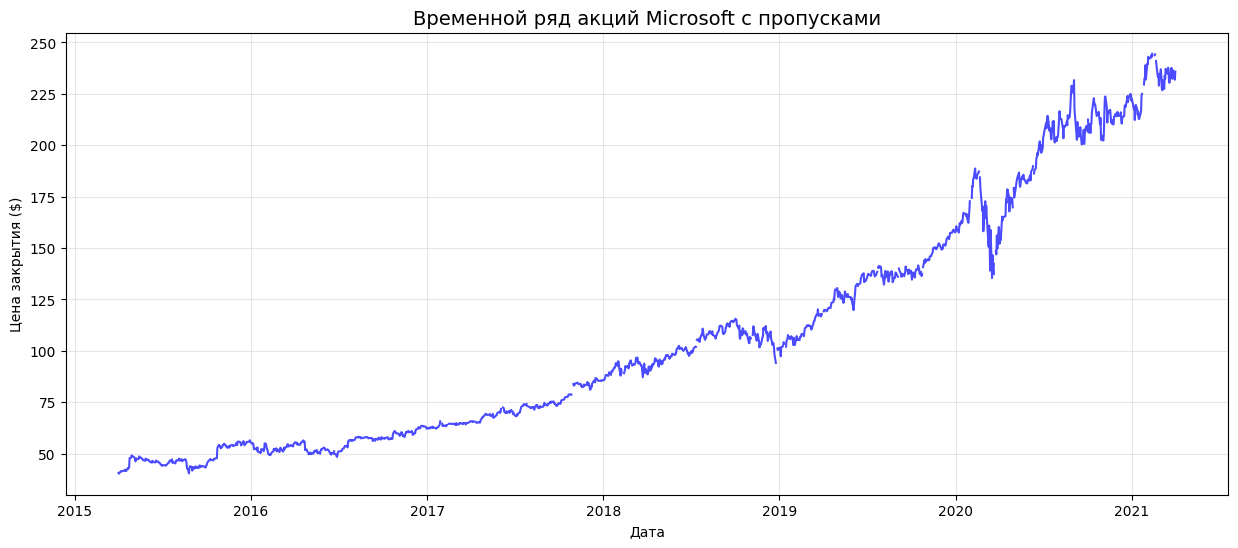

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_corrected.index, df_corrected['Close'], 'b-', alpha=0.7)
plt.title('Временной ряд акций Microsoft с пропусками', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия ($)')
plt.grid(True, alpha=0.3)
plt.show()

В данных присутствует 50 пропусков, которые отмечены разрывами на графике.



### Восстановим пропущенные значения. Опишем метод, который будем использовать для восстановления пропущенных значений

Воспользуемся линейной интерполяцией, т к она хорошо восстанавливает тренд на графике и подходит лучше всего для данных, где немного пропусков. Декомпозируем ряд, чтобы лучше заметить его особенности


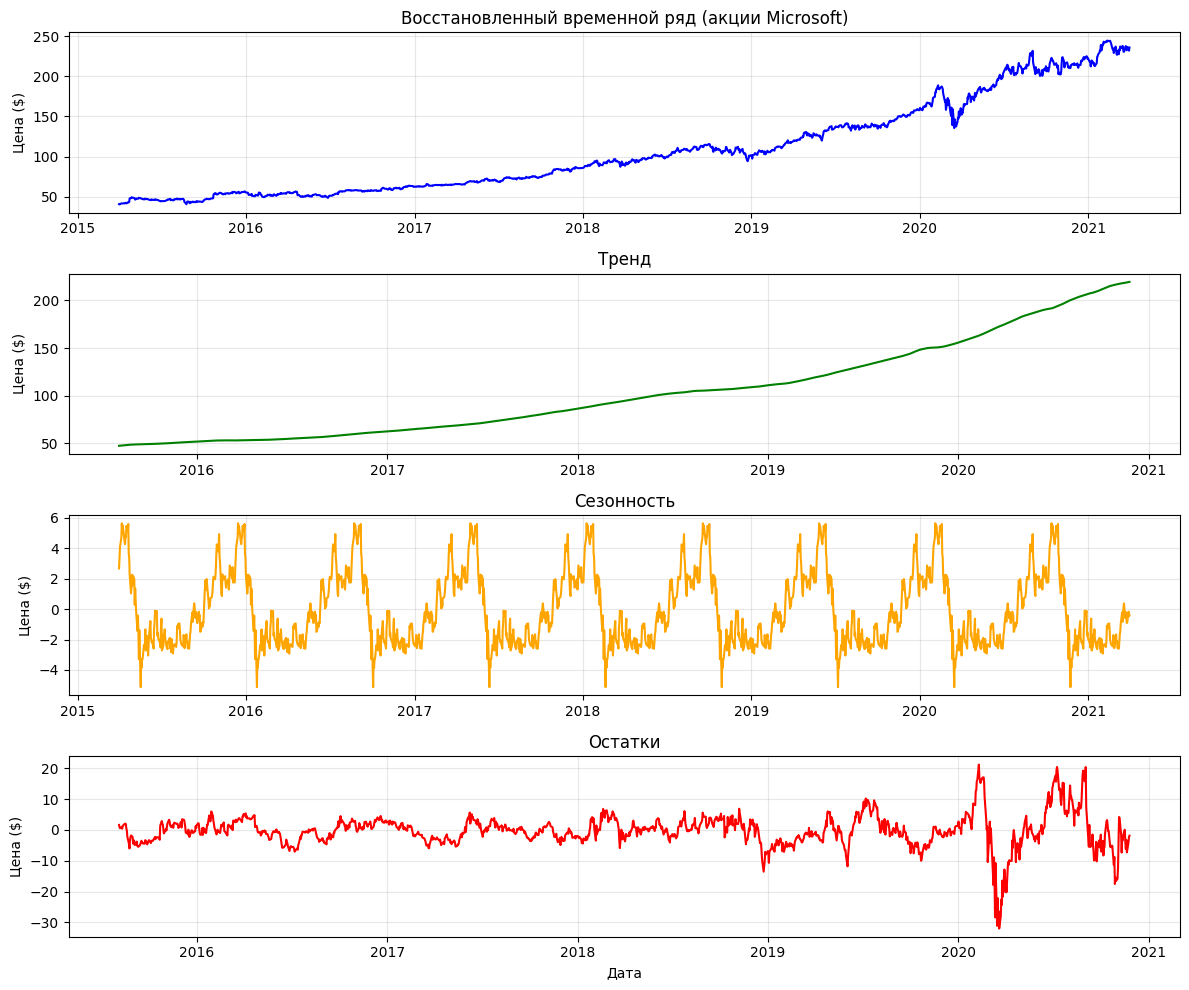

In [ ]:
df_corrected['Close'] = df_corrected['Close'].interpolate(method='linear')

df_interpolated = df_corrected.copy()

df_regular = df_corrected['Close'].resample('D').mean()
df_regular = df_regular.interpolate(method='time')

period = 252  # годовой период для финансовых данных
decomposition = seasonal_decompose(df_regular, model='additive', period=period)

plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(df_regular.index, df_regular, color='blue')
plt.title('Восстановленный временной ряд (акции Microsoft)')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomposition.trend.index, decomposition.trend, color='green')
plt.title('Тренд')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomposition.seasonal.index, decomposition.seasonal, color='orange')
plt.title('Сезонность')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomposition.resid.index, decomposition.resid, color='red')
plt.title('Остатки')
plt.ylabel('Цена ($)')
plt.xlabel('Дата')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Характеристика временного ряда:

Тренд: присутствует сильный восходящий тренд.

Сезонность: выражена, заметна на графике сезонности.

Цикл: годовые циклы с периодом 252 дня.

Волатильность остатков: высокая, особенно в 2020 году.



In [ ]:
df.set_index('Date', inplace=True)

df_origin_regular = df['Close'].resample('D').mean()
df_origin_regular = df_origin_regular.interpolate(method='time')

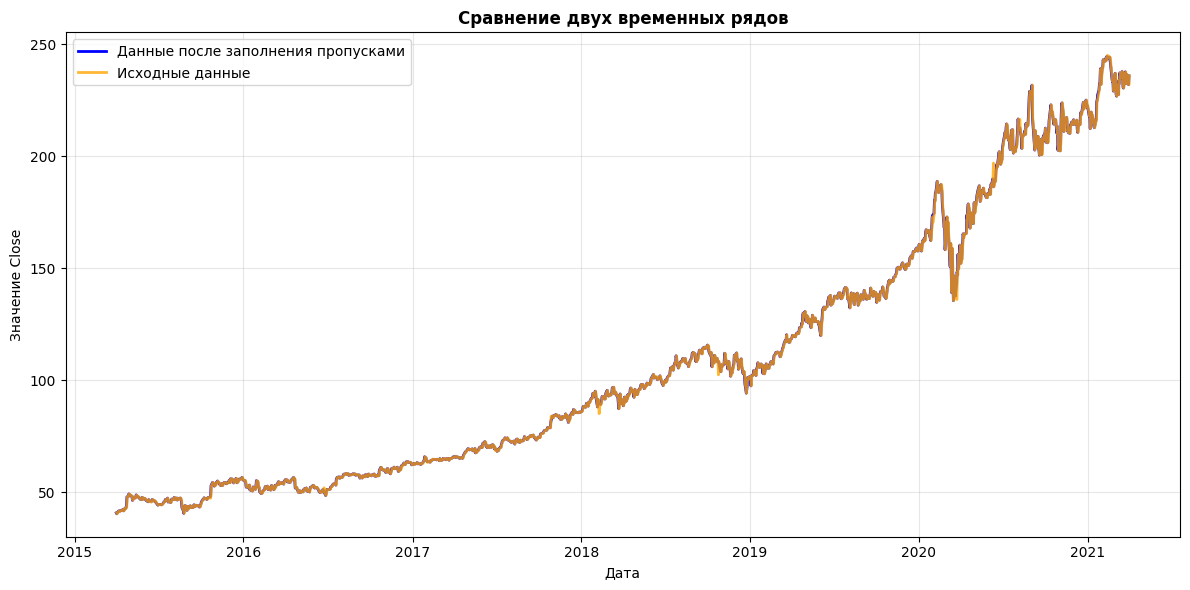

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_regular.index, df_regular.values,
         label='Данные после заполнения пропусками',
         color='blue', linewidth=2)

plt.plot(df.index, df['Close'].values,
         label='Исходные данные',
         color='orange', linewidth=2, alpha=0.8)

plt.title('Сравнение двух временных рядов', fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Значение Close')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

Можем заменить незначительное отличие на графиках между исходными данными без пропусков и данными, в которых искусственно созданные пропуски были заполнены с помощью линейной интерполяции

### Преобразуем временной ряд к стационарному виду. Опишем методы, которые использовали. Приведем график и результаты статистических тестов, подтверждающих, что ряд стал стационарным

In [ ]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(df_interpolated['Close'])
print('p-value: ', adft[1])

p-value:  0.9982025560042695


Ряд не является стационарным, нужно преобразование

In [ ]:
from statsmodels.tsa.stattools import adfuller

df_stationary = df_interpolated.copy()

df_stationary['diff_1'] = df_stationary['Close'].diff()

adf_result = adfuller(df_stationary['diff_1'].dropna()) # тест Дики-Фуллера

print("Преобразуем ряд к стационарному с помощью дифференцирования")
print(f"p-value: {adf_result[1]:.6f}")

Преобразуем ряд к стационарному с помощью дифференцирования
p-value: 0.000000


Проверили на стационарность с помощью теста Дики-Фуллера. Ряд стационарен, т к p-value < 0.05

### Построем и опишем коррелограммы (т е графики автокорреляционной функции и частной автокорреляционной функции) для временного ряда

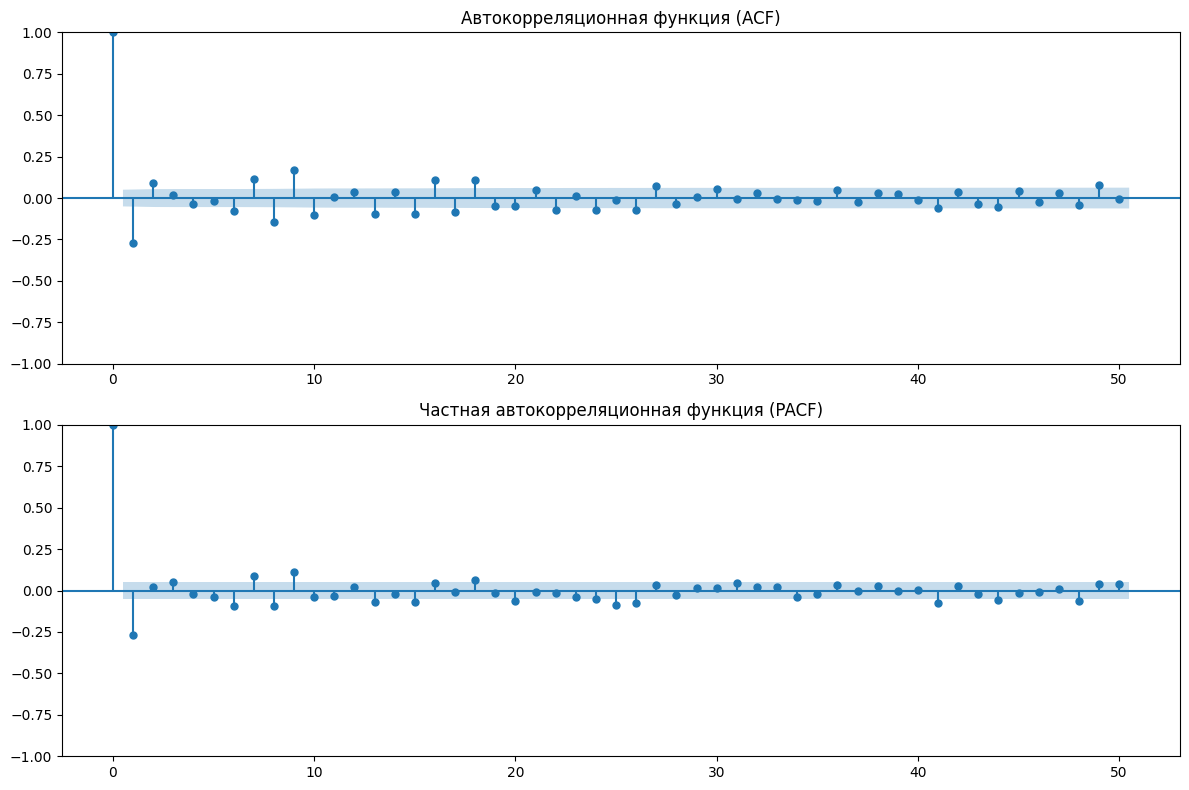

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_stationary['diff_1'].dropna(), lags=50, ax=axes[0])
axes[0].set_title('Автокорреляционная функция (ACF)')

plot_pacf(df_stationary['diff_1'].dropna(), lags=50, ax=axes[1])
axes[1].set_title('Частная автокорреляционная функция (PACF)')

plt.tight_layout()
plt.show()

на коррелограмме видим, что сезонности нет, т к на автокорреляционной функции отсутствуют периодические пики, также видно, что ряд стационарен, т к ACF имеет низкие значения

Итоги:
- Сезонная компонента не требуется
- Дифференцирование порядка d = 1 достаточно

### Разобьем выборку на обучающую и тестовую. На основе обучающей выборки идентифицируем параметры модели SARIMA. Опишем получение параметров модели p, d и q. Оценим качество модели

Разделили train/test как 80/20, т к данных достаточно много, чтобы на train обучить модель, а также на test замерить результат. В целом базовое разделение в подобных задачах

In [ ]:
train_size = int(len(df_stationary) * 0.8)
train = df_stationary['Close'][:train_size]
test = df_stationary['Close'][train_size:]

In [ ]:
from scipy.signal import periodogram

series = df_interpolated['Close'].diff().dropna().values
frequencies, power = periodogram(series)
periods = 1 / frequencies[1:]
peak_period = periods[np.argmax(power[1:])]
print(f"Наиболее вероятный период {peak_period:.0f} дня")

Наиболее вероятный период 2 дня


In [ ]:
model = auto_arima(train.dropna(),
                   seasonal=True,
                   m=2, # подставляем значение, полученное выше
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(f"Лучшая модель {model.order} + {model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=3821.899, Time=7.11 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=3845.644, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=3832.848, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=3831.045, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=3852.844, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=3828.986, Time=2.25 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=3829.082, Time=2.87 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=3823.106, Time=9.04 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=3821.415, Time=3.86 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=3821.268, Time=1.85 sec
 ARIMA(0,1,1)(0,0,2)[2] intercept   : AIC=3819.277, Time=0.61 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=3819.485, Time=2.27 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=3820.425, Time=1.18 sec
 ARIMA(0,1,0)(0,0,2)[2] intercept   : AIC=3827.747, Time=0.34 sec
 ARIMA(1,1,0)(0,0,2)[2] intercept

p = 0, d = 1, q = 1

Выбрали именно такие p, d, q, т к при переборе варинтов модель показала лучшее значение по критерию Акаике (AIC)

In [ ]:
from sklearn.metrics import mean_absolute_error

train_size = int(len(df_stationary) * 0.8)
train_prices = df_stationary['Close'].iloc[:train_size].dropna()
test_prices = df_stationary['Close'].iloc[train_size:].dropna()

model = SARIMAX(train_prices, order=(0,1,1), seasonal_order=(0, 0, 2, 2))
results = model.fit(disp=False)

n_forecast = len(test_prices)
price_forecast = results.forecast(steps=n_forecast)

actual_prices = test_prices.values

mae = mean_absolute_error(actual_prices, price_forecast)
rmse = np.sqrt(mean_squared_error(actual_prices, price_forecast))
mape = np.mean(np.abs((actual_prices - price_forecast) / actual_prices)) * 100

print("Посчитаем сразу несколько метрик, чтобы сделать более содержательные выводы")
print(f"MAE (средняя абсолютная ошибка):  {mae:.3f}")
print(f"RMSE (среднеквадратичная ошибка): {rmse:.3f}")
print(f"MAPE (средняя абсолютная процентная ошибка): {mape:.3f}%")

Посчитаем сразу несколько метрик, чтобы сделать более содержательные выводы
MAE (средняя абсолютная ошибка):  39.058
RMSE (среднеквадратичная ошибка): 44.728
MAPE (средняя абсолютная процентная ошибка): 18.324%


### Используя модель SARIMA, построим прогноз временного ряда на 30 периодов вперёд. Оценим его реалистичность

In [ ]:
prices = df_stationary['Close'].dropna()

model = auto_arima(prices,
                   seasonal=True,
                   m=2,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(f"Лучшая модель {model.order} + {model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=6677.490, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=6787.642, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=6675.206, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=6674.325, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=6790.451, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=6688.221, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=6675.767, Time=0.79 sec
 ARIMA(0,1,1)(0,0,2)[2] intercept   : AIC=6675.222, Time=0.56 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept   : AIC=6675.533, Time=0.28 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=6662.974, Time=1.88 sec
 ARIMA(0,1,1)(2,0,2)[2] intercept   : AIC=6642.690, Time=5.95 sec
 ARIMA(0,1,1)(2,0,1)[2] intercept   : AIC=6661.320, Time=3.99 sec
 ARIMA(0,1,0)(2,0,2)[2] intercept   : AIC=6720.278, Time=6.83 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=6642.013, Time=12.19 sec
 ARIMA(1,1,1)(1,0,2)[2] intercep

In [ ]:
from pandas import date_range

Построим финальный прогноз модели на следующие 30 дней

Прогноз через 30 дней: 238.56
Ожидаемое изменение: +2.79 (+1.18%)


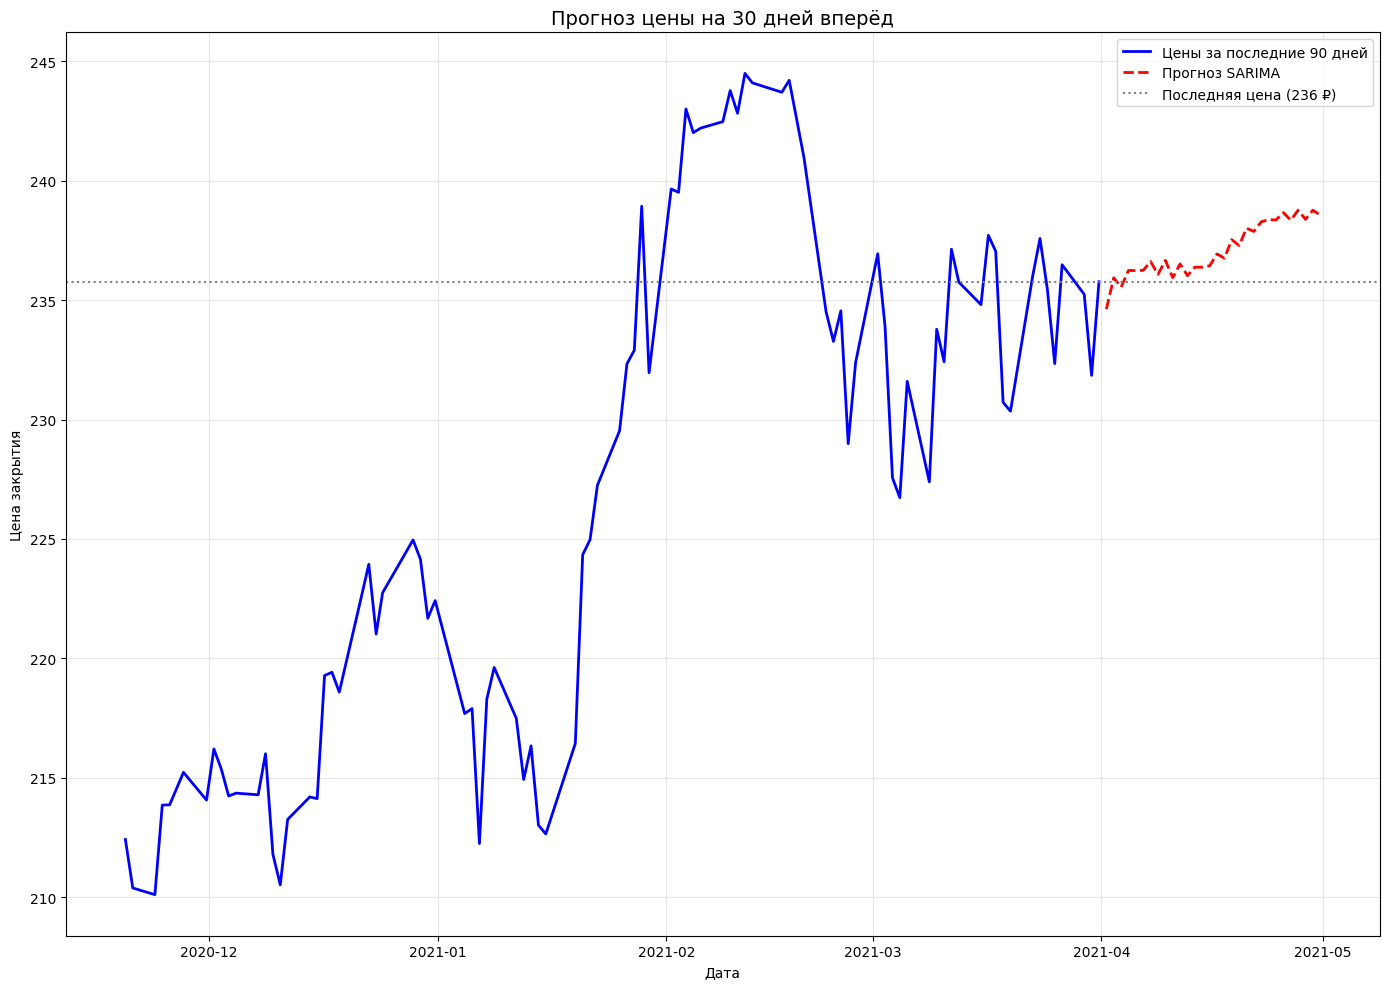

In [ ]:
final_model = SARIMAX(
    prices,
    order=(1, 1, 0),
    seasonal_order=(2, 0, 2, 2),
    trend='c'
)
final_results = final_model.fit(disp=False)

forecast_30 = final_results.forecast(steps=30)
last_price = prices.iloc[-1]
last_date = prices.index[-1]

future_dates = date_range(start=last_date + pd.Timedelta(days=1), periods=30)

print(f"Прогноз через 30 дней: {forecast_30.values[-1]:.2f}")
print(f"Ожидаемое изменение: {forecast_30.values[-1] - last_price:+.2f} ({(forecast_30.values[-1] - last_price)/last_price*100:+.2f}%)")

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))

ax1.plot(prices.index[-90:], prices.values[-90:],
         'b-', linewidth=2, label='Цены за последние 90 дней')
ax1.plot(future_dates, forecast_30.values,
         'r--', linewidth=2, label='Прогноз SARIMA')
ax1.axhline(y=last_price, color='gray', linestyle=':',
            label=f'Последняя цена ({last_price:.0f} ₽)')
ax1.set_title('Прогноз цены на 30 дней вперёд', fontsize=14)
ax1.set_xlabel('Дата')
ax1.set_ylabel('Цена закрытия')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x')

plt.tight_layout()
plt.show()

В целом прогноз выглядит реалистичным, возможно, не хватает более резких скачков, какие присутствовали на существующих данных

Дополнительно изучим это, посмотрев на волатильность прогноза

In [ ]:
hist_vol = prices[-60:].std()
forecast_vol = forecast_30.values.std()

print(f"Историческая волатильность за 60 дней: {hist_vol:.2f}")
print(f"Волатильность прогноза за 30 дней: {forecast_vol:.2f}")

if forecast_vol < hist_vol * 0.5:
    print("Возможно, прогноз недооценивает риск")
elif forecast_vol > hist_vol * 1.5:
    print("Возможно, прогноз переоценивает риск")
else:
    print("Волатильность прогноза соответствует исторической")

Историческая волатильность за 60 дней: 8.98
Волатильность прогноза за 30 дней: 1.12
Возможно, прогноз недооценивает риск
